In [1]:
import sys 
sys.path.append("..") 

#from topological_models import generator
import numpy as np
from topology_model import NonHermitianHamiltonian, NonHermitianTopologicalModel
import matplotlib.pyplot as plt
from machine_learning import Cluster
from machine_learning import Classifier
from topology_model import sigma_0, sigma_x, sigma_y, sigma_z
from topology_model import Generator
from topology_model import topology_comparator, obtain_phase_center_and_number

In [2]:
class Z21D(NonHermitianHamiltonian):
    def __init__(self, E_ref=0.):
        super().__init__(E_ref)

        self.parameters = None
        self.initiate()

    def get_n(self):
        return 2

    def get_n_dim(self):
        return 1

    def get_parameters(self):
        return self.parameters
    
    def set_parameters(self, **kwargs):
        self.parameters = kwargs['t0'], kwargs['delta'], kwargs['g']

    def initiate(self):
        t0 = 1.0
        delta = -0.3 + 0.6*np.random.random()
        g = 0.3*np.random.random()
        self.parameters = t0, delta, g

    def get_kpoints(self):
        n_points = 11
        kpoints = [[k] for k in np.linspace(0,np.pi,n_points)]
        return kpoints
    
    def get_Hamiltonian(self, k):
        k = k[0]
        t0, delta, g = self.parameters
        
        hk = 2*t0*np.cos(k)*sigma_0 + 2*delta*np.sin(k)*sigma_x + 2j*g*np.sin(k)*sigma_z
        
        hk = hk - self.E_ref*sigma_0
        return hk

class Z21DPerturbation(Z21D):
    def __init__(self, E_ref=0.):
        super().__init__(E_ref)
        self.parameters = list()
        self.initiate()

    def initiate(self):
        # different parameter region for the different gap type
        t0 = -1.0 + 2*np.random.random()
        delta = -0.3 + 0.6*np.random.random()
        g = 0.3*np.random.random()
        self.parameters = t0, delta, g
    
    def get_Hamiltonian(self, k):
        hk = super().get_Hamiltonian(k)
        hk = hk*0.05
        return hk

In [3]:
gap_type = 'point'
E_ref = 0.2j
generator = Generator(hamiltonian=Z21D(E_ref=E_ref), gap_type=gap_type)

n_sample = 100
#models, vs = generator.generate_models(n_sample)
models, vs = generator.generate_models(n_sample)
n = generator.get_n()

In [4]:
cluster = Cluster(similarity_function=topology_comparator, verbose=False)
center_indices, group_number = cluster.fit(models)
print(group_number)
print("The number of centers: ", len(center_indices))

[58 42]
The number of centers:  2


In [5]:
print("Gap type: ", gap_type)
hamiltonian_perturbation = Z21DPerturbation(E_ref=E_ref)
generator = Generator(hamiltonian=hamiltonian_perturbation, gap_type=gap_type)

n_sample = 100
perturbations, vs = generator.generate_models(n_sample)
#Qs, vs = generator.generate(n_sample)
n = generator.get_n()

new_center_indices, new_group_number = obtain_phase_center_and_number(center_indices, group_number, models, perturbations)
print("The number of phases: ", len(new_group_number))
print(new_group_number)

Gap type:  point
The number of phases:  2
[58, 42]


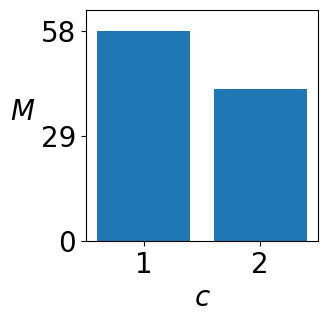

In [6]:
plt.figure(figsize=(3,3))
plt.bar(np.arange(len(new_group_number))+1, new_group_number)
plt.xlim([0.5,len(new_group_number)+0.5])
plt.xticks(list(range(1,len(new_group_number)+1)),fontsize=20)
plt.ylim([0, np.max(new_group_number)*1.1])
plt.yticks([0, int(np.max(new_group_number)/2), int(np.max(new_group_number))],fontsize=20)
plt.xlabel(r"$c$",fontsize=20)
plt.ylabel(r"$M$",fontsize=20,rotation=0,horizontalalignment='right')
plt.show()

# Phase diagram

In [7]:
classifier = Classifier(similarity_func=topology_comparator, cluster_centers=[models[index] for index in new_center_indices])

n1 = 51
n2 = 51
deltas = np.linspace(-0.3,0.3,n1)
gs = np.linspace(0,0.3,n2)

v_list = np.zeros((n1,n2))

for i in range(n1):
    for j in range(n2):
        hamiltonian = Z21D(E_ref=E_ref)
        hamiltonian.set_parameters(t0=1.0, delta=deltas[i], g=gs[j])
        #print(hamiltonian.get_parameters())
        #if hamiltonian.is_real_line_gap():
        _model = NonHermitianTopologicalModel(hamiltonian=hamiltonian, gap_type=gap_type)
        v_list[i,j] = classifier.classify(_model)

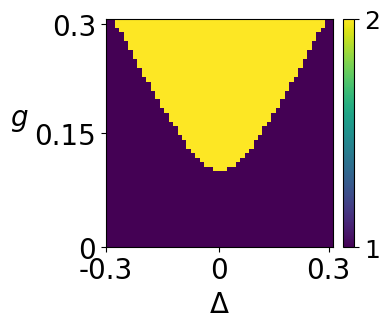

In [8]:
n1, n2 = v_list.shape

plt.figure(figsize=(4,4))
plt.imshow(np.transpose(v_list), origin='lower',extent = [0,n1,0,n2])
plt.xlabel(r"$\Delta$",fontsize=20)
plt.ylabel(r"$g$",fontsize=20, rotation=0, horizontalalignment='right')
plt.xticks([0, n1/2, n1-1],[r"-0.3", r"0", r"0.3"],fontsize=20)
plt.yticks([0, n2/2, n2-1],[r"0", r"0.15", r"0.3"], fontsize=20)

cb = plt.colorbar(ticks=range(1, len(center_indices)+1), fraction=0.046, pad=0.04)
cb.ax.tick_params(labelsize=18)

plt.tight_layout()
plt.show()

# Save data

In [10]:
from tools import save_data, save_data_M

name = "1D_Z2"
save_data(center_indices, group_number, "figs_{0}_group_number.h5".format(name))
save_data_M(v_list, "figs_{0}_phase_diagram.h5".format(name))
print(name)

1D_Z2
